# PCA Autoencoder Part I

An [interesting work](https://arxiv.org/abs/1904.01277) by Ladjal at al on autoencoders has been brought to my attention by one of my colleagues, as we are trying to leverage the nonlinearity of autoencoders to better decompose complex turbulent reacting flows. As stated in the abstract, the main goal was to improve the interpretability of Principal Component Analysis (PCA) by (1) constructing the laten space of the autoencoder with independent components that are (2) ordered by descreasing importance to the data. To achieve (1), the authors proposed to minimize the covariance of the latent codes alongside the standard loss function. The covariance term can be written as (based on Eq.1 in the paper):

$$
\Lambda_{conv}(X)=\lambda\sum_{i=1}^{k-1}\left[\frac{1}{M}\sum_{j=1}^{M}\left(z_i^jz_k^j\right) - \frac{1}{M^2}\sum_{j=1}^{M}\left(z_i^j\right)\sum_{j=1}^{M}\left(z_k^j\right)\right]
$$

where $M$ is the batch size, $z_i$ the code in the latent space. The authors introduced two modifications to a conventional CNN-based autoencoder to implement this loss function: 

- First, a BatchNormalization layer before the latent space (such that the second term above becomes 0)
- Second, add the rest of the covariance term to the total loss

I will attempt to reproduce some of the key results presented in the paper in a two-part series using TensorFlow. In this notebook, I will focus on implementing the new loss function. Instead of an additional BatchNormalization layer, I will just implement the original covrance term in a single layer, utilizing the `.add_loss()` method in custom layers in TensorFlow.  In the second part, I will look at how to achieve a hiarchichal latent space with the iterations the authors described. I will refer to the achitecture as **PCA autoencoder**, a term given by the authors in their paper.

## Synthesize dataset

In this notebook, I will just try to recreate the set of binary ellipses with only two variables (two variables) and leave out the rotation for the time being.

### Setup

In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


np.random.seed(42)
tf.random.set_seed(42)

### Phantom binary ellipses

I will use the same image dimension (64, 64) as stated in the paper. With a batch size of 500, I chose a sample size of 8000 to get 16 minibatchs per epoch (it seems the total sample size was not provided in the paper, unless I missed it).

In [2]:
def phantomEllipse(n, a, b):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return img

In [3]:
n = 64
num_batch = 16
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
dataset = np.array([phantomEllipse(n, _a, _b) for _a, _b in zip(a, b)])
dataset = dataset[..., np.newaxis]  # pay attention to the shape of the dataset!

Let's look a sample of 8 images from the dataset:

In [4]:
dataset = np.load("binary_ellipses.npy")

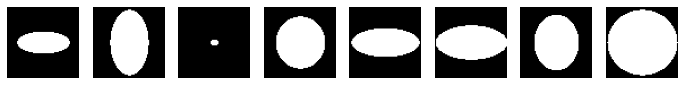

In [5]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

As can be seen, the ellipses have essentially two degrees of freedom (horizontal and vertical axes). Ideally, a latent space containing two codes in the autoencoder should surfice to capture these two main features in the dataset. Let's see what a tranditional CNN-autoencoder could do.

## CNN-autoencoder

Instead of leaky ReLU used in the paper, I will be using the standard ReLU in TensorFlow. Other than that I will try to use the same hidden layer structure provided by the authors. Note that my goals are not to optimize the autoencoder to minimize the losses. The focus is rather on the functional differences between autoencoder and the PCA encoder introduced by the authors.

### Encoder

In [6]:
activation = 'relu'
encoder = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same', input_shape=[64, 64, 1]),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(4, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2),  
])

### Deconder

In [7]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[2]),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(4, (3, 3), activation=activation, padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation=activation, padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation=activation, padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), activation=activation, padding='same'),
])

### Compile and train

In [10]:
keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
ae = keras.models.Sequential([encoder, decoder])
ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=ae.fit(dataset, dataset,
                epochs=1000,
                batch_size=500,
                shuffle=True,
                callbacks=cb)

h 00880: loss improved from 0.00277 to 0.00277, saving model to ./model_ae.hdf5
Epoch 881/1000
16/16 [==============================] - 2s 150ms/step - loss: 0.0028

Epoch 00881: loss improved from 0.00277 to 0.00277, saving model to ./model_ae.hdf5
Epoch 882/1000
16/16 [==============================] - 2s 150ms/step - loss: 0.0028

Epoch 00882: loss improved from 0.00277 to 0.00277, saving model to ./model_ae.hdf5
Epoch 883/1000
16/16 [==============================] - 2s 155ms/step - loss: 0.0027

Epoch 00883: loss did not improve from 0.00277
Epoch 884/1000
16/16 [==============================] - 3s 157ms/step - loss: 0.0028

Epoch 00884: loss improved from 0.00277 to 0.00277, saving model to ./model_ae.hdf5
Epoch 885/1000
16/16 [==============================] - 3s 157ms/step - loss: 0.0028

Epoch 00885: loss improved from 0.00277 to 0.00277, saving model to ./model_ae.hdf5
Epoch 886/1000
16/16 [==============================] - 2s 156ms/step - loss: 0.0028

Epoch 00886: loss did

### Examine the results

Let's load the best model and test it on a frame first.

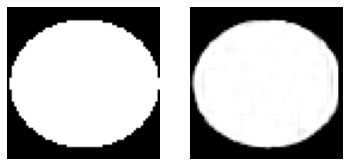

In [11]:
model = keras.models.load_model('model_ae.hdf5')
img = dataset[6430, ...]
img_rec = model.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

Alright, the model seems to work as it is supposed to. Although with just two codes in the latent space, it is obvious that it couldn't perfectly reproduce the original image. The compression is likely too lossy. Let's now try to look at the indepencies of the two codes in the latent space (Fig.2 in the original paper), which the authors referred to as the "interpolation" by fixing either one of the coodiate to 0. We can do that by extracting the decoder from the model:

In [12]:
ae_encoder = model.layers[0]
ae_encoder.predict(img[np.newaxis,...])

array([[ 1.1504265, -2.5219266]], dtype=float32)

In [14]:
coords = ae_encoder.predict(dataset)
np.mean(coords, 0)

array([ 0.48469052, -0.9571046 ], dtype=float32)

In [55]:
np.std(coords, 0)

array([9.05387  , 4.0584345], dtype=float32)

In [13]:
ae_decoder = model.layers[1]

and then supply different coordinates to it:

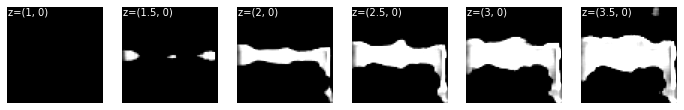

In [37]:
vals = [1, 1.5, 2, 2.5, 3, 3.5]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

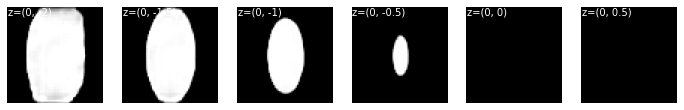

In [31]:
vals = [-2, -1.5, -1, -0.5, 0, 0.5]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

In [6]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
      super().__init__(**kwargs)
      self.lam = lam
    def call(self, inputs):
      covariance = self.lam * (tf.math.reduce_mean(tf.math.reduce_prod(inputs, 1))
                   - tf.math.reduce_prod(tf.math.reduce_mean(inputs, 0), 1))
      self.add_loss(tf.math.abs(covariance))
      return inputs
    def get_config(self):
      base_config = super().get_config()
      return {**base_config, "lam":self.lam,}

In [7]:
activation = 'relu' # partial(tf.nn.leaky_relu, alpha=0.2)
encoder = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same', input_shape=[64, 64, 1]),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(4, (3, 3), activation=activation, padding='same'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(scale=False, center=False),
    keras.layers.Dense(2),
    LatentCovarianceLayer(0.1)    
])

In [8]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[2]),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.Conv2DTranspose(4, (3, 3), activation=activation, strides=2, padding='same'),
    keras.layers.Conv2DTranspose(8, (3, 3), activation=activation, strides=2, padding='same'),
    keras.layers.Conv2DTranspose(16, (3, 3), activation=activation, strides=2, padding='same'),
    keras.layers.Conv2DTranspose(32, (3, 3), activation=activation, strides=2, padding='same'),
    keras.layers.Conv2DTranspose(1, (3, 3), activation=activation, strides=2, padding='same'),
])

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ae = keras.models.Sequential([encoder, decoder])
ae.compile(optimizer=optimizer, loss='mse')
ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 25246     
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 1)         6589      
Total params: 31,835
Trainable params: 31,803
Non-trainable params: 32
_________________________________________________________________


In [10]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           1

In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 4)           148       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 8)           296       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 1)        

In [12]:
tempfn='./model_pca_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=ae.fit(dataset, dataset,
                epochs=2000,
                batch_size=500,
                shuffle=True,
                callbacks=cb)

Epoch 262/2000
16/16 [==============================] - 2s 118ms/step - loss: 0.0079

Epoch 00262: loss improved from 0.00810 to 0.00807, saving model to ./model_pca_ae.hdf5
Epoch 263/2000
16/16 [==============================] - 2s 118ms/step - loss: 0.0079

Epoch 00263: loss did not improve from 0.00807
Epoch 264/2000
16/16 [==============================] - 2s 119ms/step - loss: 0.0087

Epoch 00264: loss did not improve from 0.00807
Epoch 265/2000
16/16 [==============================] - 2s 118ms/step - loss: 0.0083

Epoch 00265: loss did not improve from 0.00807
Epoch 266/2000
16/16 [==============================] - 2s 118ms/step - loss: 0.0080

Epoch 00266: loss did not improve from 0.00807
Epoch 267/2000
16/16 [==============================] - 2s 117ms/step - loss: 0.0082

Epoch 00267: loss did not improve from 0.00807
Epoch 268/2000
16/16 [==============================] - 2s 119ms/step - loss: 0.0087

Epoch 00268: loss did not improve from 0.00807
Epoch 269/2000
16/16 [======

In [13]:
model = keras.models.load_model('model_pca_ae.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

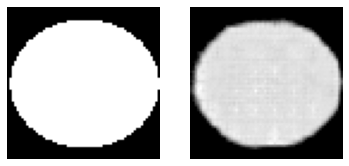

In [14]:
img = dataset[6430, ...]
img_rec = model.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'))
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'))
ax[1].axis('off')
plt.show()

In [15]:
decoder = model.layers[1]

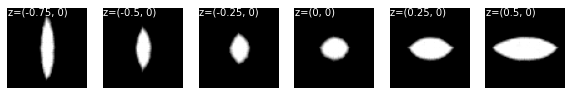

In [19]:
vals = [-0.75, -0.5, -0.25, 0, 0.25, 0.5]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()


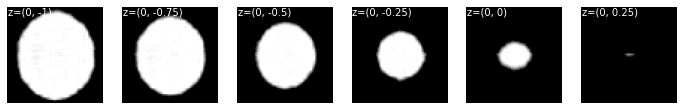

In [21]:
vals = [-1, -0.75, -0.5, -0.25, 0, 0.25]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()